In [1]:
%pip install --quiet geopandas
%pip install --quiet --no-deps "git+https://github.com/uba/tathu.git"
%pip install -q scikit-image scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install arm-pyart==1.19.0 xarray-datatree==0.0.14 xarray==2024.9.0

In [4]:
import pyart
import glob


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [5]:
#####################################################################################################
dato_radar_inicial="datos/RMA1_0303_01_20241128T200036Z.nc"
dato_radar_current_1="datos/RMA1_0303_01_20241128T201336Z.nc"
dato_radar_current_2="datos/RMA1_0303_01_20241128T202635Z.nc"
dato_radar_current_3="datos/RMA1_0303_01_20241128T203936Z.nc"
dato_radar_current_4="datos/RMA1_0303_01_20241128T205235Z.nc"

#####################################################################################################
dato_radar_inicial = pyart.io.read(dato_radar_inicial)
dato_radar_current_1 = pyart.io.read(dato_radar_current_1)
dato_radar_current_2 = pyart.io.read(dato_radar_current_2)
dato_radar_current_3 = pyart.io.read(dato_radar_current_3)
dato_radar_current_4 = pyart.io.read(dato_radar_current_4)

#####################################################################################################

In [6]:
## CREAMOS EL SYSTEMS PARA EL PRIMER DATO DE RADAR
from pyart.map import grid_from_radars
#####################################################################################################
# Crea grilla: 10 niveles verticales de 0 a 10 km, en 100x100 km horizontal
grid_inicial = grid_from_radars(
    (dato_radar_inicial,),
    grid_shape=(10, 200, 200),  # Z, Y, X → 10 niveles, 200x200 horizontal
    grid_limits=((0, 10000), (-100000, 100000), (-100000, 100000)),  # Z, Y, X en metros
    fields=['DBZH'])
#####################################################################################################
### AHORA HACEMOs LO MISMO PARA EL SEGUNDO DATO DE RADAR #################################
# Crea grilla: 10 niveles verticales de 0 a 10 km, en 100x100 km horizontal
grid_current_1 = grid_from_radars(
    (dato_radar_current_1,),
    grid_shape=(10, 200, 200),  # Z, Y, X → 10 niveles, 200x200 horizontal
    grid_limits=((0, 10000), (-100000, 100000), (-100000, 100000)),  # Z, Y, X en metros
    fields=['DBZH'])
#####################################################################################################
# Crea grilla: 10 niveles verticales de 0 a 10 km, en 100x100 km horizontal
### PARA EL TERCER DATO DE RADAR QUE USAMOS PARA CORROBORAR ####################
grid_current_2 = grid_from_radars(
    (dato_radar_current_2,),
    grid_shape=(10, 200, 200),  # Z, Y, X → 10 niveles, 200x200 horizontal
    grid_limits=((0, 10000), (-100000, 100000), (-100000, 100000)),  # Z, Y, X en metros
    fields=['DBZH'])
### PARA EL TERCER DATO DE RADAR QUE USAMOS PARA CORROBORAR ####################
grid_current_3 = grid_from_radars(
    (dato_radar_current_3,),
    grid_shape=(10, 200, 200),  # Z, Y, X → 10 niveles, 200x200 horizontal
    grid_limits=((0, 10000), (-100000, 100000), (-100000, 100000)),  # Z, Y, X en metros
    fields=['DBZH'])
### PARA EL TERCER DATO DE RADAR QUE USAMOS PARA CORROBORAR ####################
grid_current_4 = grid_from_radars(
    (dato_radar_current_4,),
    grid_shape=(10, 200, 200),  # Z, Y, X → 10 niveles, 200x200 horizontal
    grid_limits=((0, 10000), (-100000, 100000), (-100000, 100000)),  # Z, Y, X en metros
    fields=['DBZH'])

In [11]:
#### ESTA FUNCIóN PERMITE GRAFICAR EN UNA MISMA FILA LOS SISTEMAS de DIFERENTES datos ##########################
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from skimage import measure
import scipy.ndimage as ndi
from matplotlib.colors import ListedColormap

def detectar_sistemas_convectivos_visual(grid, nivel=0, umbral_dbz=40, min_area_km2=80,
                                   extent_km=200, plot=True, return_axes=False, return_mask=False):

    dbz_slice = grid.fields['DBZH']['data'][nivel, :, :]
    binary = dbz_slice > umbral_dbz
    labeled_array, num_features = ndi.label(binary)
    areas = ndi.sum(binary, labeled_array, index=np.arange(1, num_features+1))

    pixel_spacing_km = extent_km / labeled_array.shape[0]
    pixel_area_km2 = pixel_spacing_km ** 2
    valid_labels = [i+1 for i, area in enumerate(areas) if area * pixel_area_km2 >= min_area_km2]
    mask = np.isin(labeled_array, valid_labels)

    fig, ax = None, None
    if (plot or return_axes) and np.any(mask):
        fig, ax = plt.subplots(figsize=(8, 6))
        cmap = ListedColormap(['white', 'black'])
        im = ax.imshow(mask, cmap=cmap, origin='lower')
        ax.set_title(f'Sistemas detectados - nivel {nivel} ({grid.z["data"][nivel]:.0f} m)')
        fig.colorbar(im, ax=ax)
        ax.grid(True)
        if plot:
            plt.show()

    # Extraer contornos y atributos
    x_min = -extent_km / 2
    y_min = -extent_km / 2
    systems = []

    for label in valid_labels:
        region_mask = labeled_array == label
        contours = measure.find_contours(region_mask, 0.5)
        if not contours:
            continue
        contour = max(contours, key=len)
        row = contour[:, 0]
        col = contour[:, 1]
        x = x_min + col * pixel_spacing_km
        y = y_min + row * pixel_spacing_km
        poly = Polygon(zip(x, y))
        if not poly.is_valid or poly.area == 0:
            continue
        systems.append({
            'id': label,
            'geometry': poly,
            'centroid': poly.centroid,
            'area_km2': poly.area,
            'max_dbz': np.max(dbz_slice[region_mask]),
            'mean_dbz': np.mean(dbz_slice[region_mask])
        })

    # retorno
    if return_axes:
        return systems, fig, ax
    elif return_mask:
        return systems, mask
    else:
        return systems


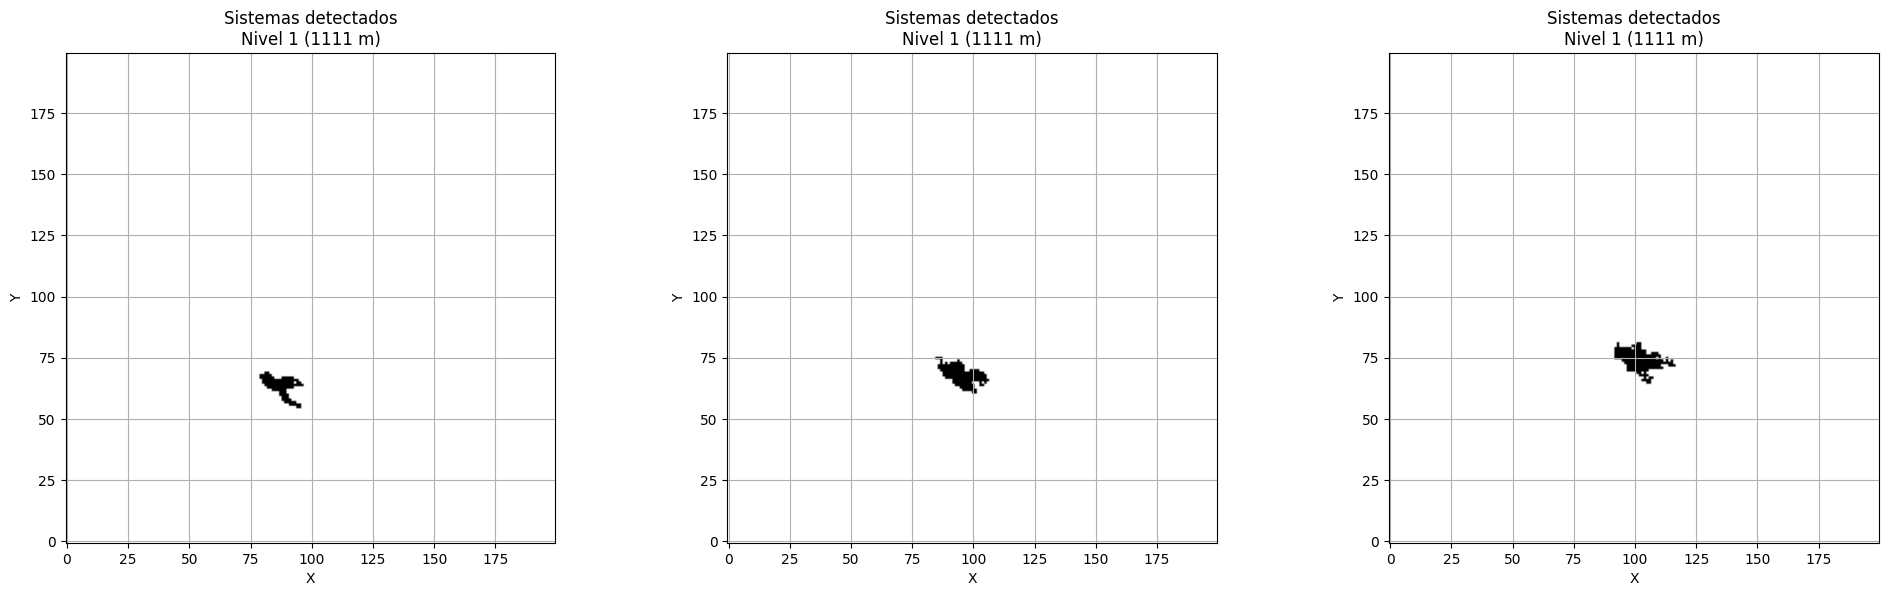

In [12]:
fig, axs = plt.subplots(1,3, figsize=(20, 6))
grids = [grid_inicial, grid_current_1, grid_current_2]

for i, grid in enumerate(grids):
    systems, mask = detectar_sistemas_convectivos_visual(grid, nivel=2, umbral_dbz=35,
                                                   min_area_km2=100, extent_km=200,
                                                   plot=False, return_mask=True)

    axs[i].imshow(mask, cmap=ListedColormap(['white', 'black']), origin='lower')
    axs[i].set_title(f"Sistemas detectados\nNivel 1 ({grid.z['data'][1]:.0f} m)")
    axs[i].set_xlabel("X")
    axs[i].set_ylabel("Y")
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [7]:
################################################################################
# FASE 1: IDENTIFICACIÓN MULTI-UMBRAL CON MORFOLOGÍA MATEMÁTICA
################################################################################

def detectar_sistemas_etitan(grid, nivel=0, umbrales_dbz=[35, 40, 45, 50], 
                             min_area_km2=100, extent_km=200, plot=False):
    """
    Identificación de sistemas convectivos usando método multi-umbral ETITAN.
    
    Mejora sobre TITAN: usa múltiples umbrales para separar células 
    adyacentes que se fusionan falsamente con un solo umbral.
    
    Parameters:
    -----------
    grid : PyART grid object
    nivel : int, nivel vertical a analizar
    umbrales_dbz : list, umbrales de reflectividad en orden ascendente
    min_area_km2 : float, área mínima para considerar un sistema
    extent_km : float, extensión espacial del dominio
    plot : bool, visualizar resultados
    
    Returns:
    --------
    systems : list de diccionarios con sistemas identificados
    """
    
    # 1. Extraer reflectividad
    dbz_slice = grid.fields['DBZH']['data'][nivel, :, :]
    pixel_spacing_km = extent_km / dbz_slice.shape[0]
    pixel_area_km2 = pixel_spacing_km ** 2
    
    # 2. Identificación multi-umbral con morfología
    systems_multi = []
    
    for i, umbral in enumerate(umbrales_dbz):
        # 2a. Umbralización
        binary = dbz_slice > umbral
        
        # 2b. Operaciones morfológicas para separar células fusionadas
        if i > 0:
            # Erosión: reduce regiones, separa células conectadas débilmente
            struct = morphology.disk(1)  # elemento estructurante
            binary = morphology.binary_erosion(binary, struct)
        
        # 2c. Etiquetado de componentes
        labeled_array, num_features = ndi.label(binary)
        
        # 2d. Filtro por área
        for label in range(1, num_features + 1):
            mask = labeled_array == label
            area_pixels = np.sum(mask)
            area_km2 = area_pixels * pixel_area_km2
            
            if area_km2 >= min_area_km2:
                # 2e. Dilatación para recuperar tamaño original (si hubo erosión)
                if i > 0:
                    mask_dilated = morphology.binary_dilation(mask, struct)
                    # Intersección con umbral original para no crecer demasiado
                    mask = mask_dilated & (dbz_slice > umbral)
                
                # 2f. Extraer contorno y geometría
                contours = measure.find_contours(mask.astype(float), 0.5)
                if not contours:
                    continue
                
                contour = max(contours, key=len)
                x_min = -extent_km / 2
                y_min = -extent_km / 2
                
                row = contour[:, 0]
                col = contour[:, 1]
                x = x_min + col * pixel_spacing_km
                y = y_min + row * pixel_spacing_km
                
                poly = Polygon(zip(x, y))
                if not poly.is_valid or poly.area == 0:
                    continue
                
                # 2g. Calcular atributos
                centroid = poly.centroid
                max_dbz = np.max(dbz_slice[mask])
                mean_dbz = np.mean(dbz_slice[mask])
                
                systems_multi.append({
                    'id': len(systems_multi) + 1,
                    'threshold_level': i,
                    'threshold_dbz': umbral,
                    'geometry': poly,
                    'centroid': centroid,
                    'area_km2': poly.area,
                    'max_dbz': max_dbz,
                    'mean_dbz': mean_dbz,
                    'mask': mask
                })
    
    # 3. Fusionar núcleos de diferentes umbrales que pertenecen al mismo sistema
    systems_final = fusionar_nucleos_multiumbral(systems_multi)
    
    # 4. Visualización
    if plot:
        visualizar_deteccion_multiumbral(dbz_slice, systems_multi, systems_final, 
                                        umbrales_dbz, extent_km, nivel, grid)
    
    return systems_final

In [8]:
################################################################################
# FASE 2: TRACKING CON RESTRICCIONES DINÁMICAS
################################################################################

def tracking_etitan(systems_old, systems_new, max_distance_km=20, 
                   velocity_history=None, dt_minutes=5):
    """
    Tracking con optimización combinatoria y restricciones dinámicas (ETITAN).
    
    Mejoras sobre tracking simple:
    - Usa overlapping (superposición de geometrías)
    - Restricción dinámica de velocidad basada en historial
    - Considera características físicas adicionales
    
    Parameters:
    -----------
    systems_old : list, sistemas en tiempo t
    systems_new : list, sistemas en tiempo t+1
    max_distance_km : float, distancia máxima base
    velocity_history : dict, {system_id: (vx, vy)} velocidades previas
    dt_minutes : float, intervalo temporal en minutos
    
    Returns:
    --------
    matches : list de diccionarios con correspondencias
    """
    
    n_old = len(systems_old)
    n_new = len(systems_new)
    
    if n_old == 0 or n_new == 0:
        return []
    
    # 1. Construir matriz de costos multi-criterio
    cost_matrix = np.full((n_old, n_new), np.inf)
    
    for i, old in enumerate(systems_old):
        # Restricción dinámica de velocidad
        if velocity_history and old['id'] in velocity_history:
            vx, vy = velocity_history[old['id']]
            v_mag = np.sqrt(vx**2 + vy**2)
            # Permitir 50% de variación sobre velocidad histórica
            max_dist_dynamic = max(max_distance_km, v_mag * dt_minutes/60 * 1.5)
        else:
            max_dist_dynamic = max_distance_km
        
        old_centroid = np.array([old['centroid'].x, old['centroid'].y])
        
        for j, new in enumerate(systems_new):
            new_centroid = np.array([new['centroid'].x, new['centroid'].y])
            
            # A. Distancia de centroides
            distance = np.linalg.norm(old_centroid - new_centroid)
            
            if distance > max_dist_dynamic:
                continue  # Fuera del rango dinámico
            
            # B. Superposición geométrica (técnica de overlapping)
            try:
                intersection = old['geometry'].intersection(new['geometry'])
                union = old['geometry'].union(new['geometry'])
                overlap_ratio = intersection.area / union.area if union.area > 0 else 0
            except:
                overlap_ratio = 0
            
            # C. Similitud de área
            area_diff = abs(new['area_km2'] - old['area_km2'])
            area_mean = (new['area_km2'] + old['area_km2']) / 2
            area_similarity = 1 - min(area_diff / area_mean, 1.0)
            
            # D. Similitud de intensidad
            dbz_diff = abs(new['max_dbz'] - old['max_dbz'])
            dbz_similarity = 1 - min(dbz_diff / 20.0, 1.0)
            
            # E. Costo combinado (pesos ajustables)
            w_dist = 0.4
            w_overlap = 0.3
            w_area = 0.2
            w_dbz = 0.1
            
            cost = (w_dist * (distance / max_dist_dynamic) + 
                   w_overlap * (1 - overlap_ratio) +
                   w_area * (1 - area_similarity) +
                   w_dbz * (1 - dbz_similarity))
            
            cost_matrix[i, j] = cost
    
    # 2. Resolver asignación óptima con algoritmo húngaro
    filas_validas = ~np.all(np.isinf(cost_matrix), axis=1)
    columnas_validas = ~np.all(np.isinf(cost_matrix), axis=0)
    
    if not np.any(filas_validas) or not np.any(columnas_validas):
        return []
    
    submatrix = cost_matrix[np.ix_(filas_validas, columnas_validas)]
    row_sub, col_sub = linear_sum_assignment(submatrix)
    
    row_ind = np.where(filas_validas)[0][row_sub]
    col_ind = np.where(columnas_validas)[0][col_sub]
    
    # 3. Construir matches
    matches = []
    for i, j in zip(row_ind, col_ind):
        if cost_matrix[i, j] != np.inf:
            old_centroid = np.array([systems_old[i]['centroid'].x,
                                    systems_old[i]['centroid'].y])
            new_centroid = np.array([systems_new[j]['centroid'].x,
                                    systems_new[j]['centroid'].y])
            
            distance = np.linalg.norm(old_centroid - new_centroid)
            
            # Calcular velocidad
            vx = (new_centroid[0] - old_centroid[0]) / (dt_minutes / 60)
            vy = (new_centroid[1] - old_centroid[1]) / (dt_minutes / 60)
            
            matches.append({
                'old_id': systems_old[i]['id'],
                'new_id': systems_new[j]['id'],
                'distance_km': distance,
                'velocity_x': vx,
                'velocity_y': vy,
                'velocity_mag': np.sqrt(vx**2 + vy**2),
                'cost': cost_matrix[i, j]
            })
    
    return matches

In [9]:
################################################################################
# FASE 3: PRONÓSTICO CON OPTICAL FLOW (CORRELACIÓN CRUZADA)
################################################################################

def pronosticar_posiciones_etitan(systems_current, velocity_history, 
                                  forecast_minutes=10):
    """
    Pronóstico de posiciones futuras usando vectores de movimiento.
    
    ETITAN usa el campo de vectores calculado por correlación cruzada.
    Aquí usamos las velocidades del tracking.
    
    Parameters:
    -----------
    systems_current : list, sistemas actuales
    velocity_history : dict, {system_id: (vx, vy)}
    forecast_minutes : int, tiempo de pronóstico en minutos
    
    Returns:
    --------
    systems_forecast : list con posiciones pronosticadas
    """
    
    systems_forecast = []
    dt_hours = forecast_minutes / 60
    
    for sys in systems_current:
        if sys['id'] not in velocity_history:
            continue
        
        vx, vy = velocity_history[sys['id']]
        
        # Pronóstico de centroide
        x_forecast = sys['centroid'].x + vx * dt_hours
        y_forecast = sys['centroid'].y + vy * dt_hours
        
        # Pronóstico de geometría (traslación)
        from shapely import affinity
        geometry_forecast = affinity.translate(sys['geometry'], 
                                              xoff=vx * dt_hours,
                                              yoff=vy * dt_hours)
        
        systems_forecast.append({
            'id': sys['id'],
            'geometry': geometry_forecast,
            'centroid': Point(x_forecast, y_forecast),
            'area_km2': sys['area_km2'],
            'max_dbz': sys['max_dbz'],
            'mean_dbz': sys['mean_dbz'],
            'velocity_x': vx,
            'velocity_y': vy,
            'forecast_time_min': forecast_minutes
        })
    
    return systems_forecast


In [10]:
################################################################################
# UTILIDADES
################################################################################

def construir_trayectorias_etitan(lista_sistemas, lista_matches):
    """
    Construye trayectorias completas a partir de matches secuenciales.
    
    Parameters:
    -----------
    lista_sistemas : list de listas, [[sys_t0], [sys_t1], [sys_t2], ...]
    lista_matches : list de listas, [[matches_0_1], [matches_1_2], ...]
    
    Returns:
    --------
    trajectories : dict, {traj_id: [system_info_t0, system_info_t1, ...]}
    """
    
    trajectories = defaultdict(list)
    system_to_traj = {}  # Mapeo system_id -> trajectory_id
    next_traj_id = 1
    
    # Inicializar con sistemas del primer tiempo
    for sys in lista_sistemas[0]:
        system_to_traj[('t0', sys['id'])] = next_traj_id
        trajectories[next_traj_id].append({
            'time_step': 0,
            'system': sys
        })
        next_traj_id += 1
    
    # Propagar a través de los matches
    for t, matches in enumerate(lista_matches):
        for match in matches:
            old_key = (f't{t}', match['old_id'])
            
            if old_key in system_to_traj:
                traj_id = system_to_traj[old_key]
                new_key = (f't{t+1}', match['new_id'])
                system_to_traj[new_key] = traj_id
                
                # Encontrar sistema correspondiente
                for sys in lista_sistemas[t+1]:
                    if sys['id'] == match['new_id']:
                        trajectories[traj_id].append({
                            'time_step': t+1,
                            'system': sys,
                            'velocity': (match['velocity_x'], match['velocity_y'])
                        })
                        break
        
        # Sistemas nuevos no mapeados (nuevas trayectorias)
        matched_new_ids = {m['new_id'] for m in matches}
        for sys in lista_sistemas[t+1]:
            new_key = (f't{t+1}', sys['id'])
            if new_key not in system_to_traj:
                system_to_traj[new_key] = next_traj_id
                trajectories[next_traj_id].append({
                    'time_step': t+1,
                    'system': sys
                })
                next_traj_id += 1
    
    return dict(trajectories)

In [11]:
def actualizar_velocidad_history(velocity_history, matches):
    """
    Actualiza el historial de velocidades con los nuevos matches.
    """
    if velocity_history is None:
        velocity_history = {}
    
    for match in matches:
        velocity_history[match['new_id']] = (match['velocity_x'], 
                                            match['velocity_y'])
    
    return velocity_history

In [12]:
def visualizar_deteccion_multiumbral(dbz_slice, systems_multi, systems_final,
                                    umbrales_dbz, extent_km, nivel, grid):
    """Visualiza resultados de detección multi-umbral."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Panel 1: Todos los núcleos detectados
    ax = axes[0]
    im = ax.imshow(dbz_slice, cmap='pyart_NWSRef', origin='lower',
                   extent=[-extent_km/2, extent_km/2, -extent_km/2, extent_km/2],
                   vmin=0, vmax=70)
    
    colors = ['red', 'orange', 'yellow', 'white']
    for sys in systems_multi:
        color = colors[min(sys['threshold_level'], len(colors)-1)]
        x, y = sys['geometry'].exterior.xy
        ax.plot(x, y, color=color, linewidth=2, alpha=0.7,
               label=f"≥{sys['threshold_dbz']} dBZ" if sys['threshold_level'] < 4 else "")
    
    ax.set_title(f'Núcleos Multi-Umbral - Nivel {nivel}')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    plt.colorbar(im, ax=ax, label='Reflectividad (dBZ)')
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    ax.grid(True, alpha=0.3)
    
    # Panel 2: Sistemas finales fusionados
    ax = axes[1]
    im = ax.imshow(dbz_slice, cmap='pyart_NWSRef', origin='lower',
                   extent=[-extent_km/2, extent_km/2, -extent_km/2, extent_km/2],
                   vmin=0, vmax=70)
    
    for i, sys in enumerate(systems_final):
        x, y = sys['geometry'].exterior.xy
        ax.plot(x, y, color='cyan', linewidth=3)
        ax.plot(sys['centroid'].x, sys['centroid'].y, 'r*', markersize=15)
        ax.text(sys['centroid'].x, sys['centroid'].y, f"S{sys['id']}",
               color='white', fontsize=12, weight='bold',
               bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        
        # Mostrar núcleos internos
        for core in sys['cores']:
            if core['threshold_level'] > 0:
                xc, yc = core['geometry'].exterior.xy
                ax.plot(xc, yc, 'yellow', linewidth=1, linestyle='--', alpha=0.5)
    
    ax.set_title(f'Sistemas Finales (n={len(systems_final)})')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    plt.colorbar(im, ax=ax, label='Reflectividad (dBZ)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()